# Modeling Notebook

This notebook goes through the stages of modeling before landing on the final Random Forest model used to predict revenue for visits to Google's online store.

**Sections:**
* Importing Data
* Baseline KNN Model
* Tuned KNN Models
* Baseline Decision Tree Model
* Random Forest Models
* Feature Engineering
* Final Model & Evaluation

# Import Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
from sklearn.metrics import calinski_harabasz_score
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)

Import preprocessed data.

In [153]:
df = pd.read_csv('../Data/final_data.csv', dtype={'fullVisitorId': 'str'})
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 30 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   date                                          717217 non-null  object 
 2   device_browser                                717217 non-null  object 
 3   device_deviceCategory                         717217 non-null  object 
 4   device_isMobile                               717217 non-null  bool   
 5   device_operatingSystem                        717217 non-null  object 
 6   fullVisitorId                                 717217 non-null  object 
 7   totals_hits                                   717217 non-null  int64  
 8   totals_pageviews                              717217 non-null  float64
 9   totals_sessionQualityDim                      71

Drop features that do not have predictive capabilities, are duplicates of revenue, or are otherwise unsuitable for regression modeling.

In [2]:
# Filter df for modeling
dfm = df.copy()
dfm.drop(['time', 'totals_totalTransactionRevenue', 'totals_transactionRevenue', 'date', 'fullVisitorId', 'visitId', 'total_revenue_usd', 'totals_transactions', 'purchase'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   device_browser                                717217 non-null  object 
 2   device_deviceCategory                         717217 non-null  object 
 3   device_isMobile                               717217 non-null  bool   
 4   device_operatingSystem                        717217 non-null  object 
 5   totals_hits                                   717217 non-null  int64  
 6   totals_pageviews                              717217 non-null  float64
 7   totals_sessionQualityDim                      717217 non-null  float64
 8   totals_timeOnSite                             717217 non-null  float64
 9   trafficSource_adContent                       71

# Modeling

Now we begin the modeling stage.

# Train Test Split

Split the data into dependent and independent variables for modeling.  Then split into train and test sets.  All model tuning will be done using cross validation on the training data.  The test data will be used only to test the results of the final model.

In [4]:
X = dfm.drop('revenue_usd', axis=1)
Y = dfm['revenue_usd']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=70)

Creating dummy variables with get_dummies.  get_dummies does not drop any categorical columns.  This is not a problem for KNN Regressor, but would need to be updated for models like linear regression.

In [6]:
X_train_ohe = pd.get_dummies(X_train)
X_train_ohe.head()

,device_isMobile,totals_hits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,trafficSource_adwordsClickInfo.page,visitNumber,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,...,trafficSource_source_sites.google.com,trafficSource_source_t.co,trafficSource_source_yahoo,trafficSource_source_youtube.com,time_of_day_Afternoon,time_of_day_Early Morning,time_of_day_Evening,time_of_day_Late Night,time_of_day_Morning,time_of_day_Night
678941,False,9,7.0,2.0,239.509969,0.0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
561021,False,11,7.0,31.0,239.509969,0.0,5,0,0,0,...,0,0,0,0,0,0,1,0,0,0
153899,False,9,7.0,-1.0,239.509969,0.0,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
54930,False,4,4.0,-1.0,239.509969,0.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
628845,False,48,28.0,70.0,239.509969,0.0,33,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Now the data is ready for regression modeling.

# Baseline KNN Model

First we run an untuned model to establish a baseline. Normally wouldn't use PCA in the baseline model, but our computational resources are too limited to make predictions without PCA.  All data must be scaled before using any KNN model.

In [73]:
pipe_knn_baseline = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.9)),
            ('knn', KNeighborsRegressor(p=2, n_jobs=-1))])

Here we will implement a GridSearchCV only for its cross validation properties.  All hyperparameters will be the default values in this baseline model.

In [74]:
# Create the grid parameter
grid_knn_baseline = [{'knn__n_neighbors': [5], 
         'knn__weights': ['uniform']}]

# Create the grid, with "pipe" as the estimator
gridsearch_knn_baseline = GridSearchCV(estimator=pipe_knn_baseline, 
                          param_grid=grid_knn_baseline, 
                          scoring=['r2', 'neg_root_mean_squared_error'], 
                          refit='r2',
                          cv=5,
                          n_jobs=-1)

In [75]:
gridsearch_knn_baseline.fit(X_train_ohe, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=0.9)),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': [5],
                          'knn__weights': ['uniform']}],
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [77]:
#Save the model
dump(gridsearch_knn_baseline, 'gridsearch_knn_baseline.joblib') 

['gridsearch_knn_baseline.joblib']

In [78]:
gridsearch_knn_baseline_df = pd.DataFrame.from_dict(gridsearch_knn_baseline.cv_results_)
gridsearch_knn_baseline_df['mean_test_r2']

0   -0.046531
Name: mean_test_r2, dtype: float64

In [79]:
gridsearch_knn_baseline.best_score_

-0.046531300371287145

The mean R-Squared value across all folds of cross validation is -0.0465.  This is not high at all (in fact it's negative!), so we will tune our hyperparameters in order to achieve better results.

# Tuned KNN Model

Now we will tune our KNN model's hyperparameters for the number of nearest neighbors and the weight function used in prediction.

In [80]:
#Create pipeline
pipe_knn = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.9)),
            ('knn', KNeighborsRegressor(p=2, n_jobs=-1))])

In [81]:
# Create the grid parameter
grid_knn = [{'knn__n_neighbors': [5, 10, 20, 50, 100], 
         'knn__weights': ['uniform', 'distance']}]

# Create the grid, with "pipe" as the estimator
gridsearch_knn = GridSearchCV(estimator=pipe_knn, 
                          param_grid=grid_knn, 
                          scoring=['r2', 'neg_root_mean_squared_error'], 
                          refit='r2',
                          cv=5,
                          n_jobs=-1)

In [82]:
gridsearch_knn.fit(X_train_ohe, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=0.9)),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': [5, 10, 20, 50, 100],
                          'knn__weights': ['uniform', 'distance']}],
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

Throughout the notebook the dump/load functions are used to save and load models so that we do not have to re-fit models each time the notebook/kernel is closed or restarted.

In [83]:
#Save the model
dump(gridsearch_knn, 'gridsearch_knn.joblib') 

['gridsearch_knn.joblib']

In [84]:
gridsearch_knn.best_params_

{'knn__n_neighbors': 50, 'knn__weights': 'distance'}

In [85]:
gridsearch_knn.best_score_

0.12583662687409544

The best model we tested used a distance weight function and 50 nearest neighbors to make its predictions.  The average R-Squared value for this model across all CV folds was 12.6%.  This model also had the 2nd lowest RMSE out of the models we tried.  This is a definite improvement over our baseline model.

Next, we can graph how R-Squared and RMSE change as we modify the number of neighbors.  This will allow us to more accurately target the hyperparameters that will lead to the best result.

In [86]:
#Get results of our modeling.
gridsearch_knn_df = pd.DataFrame.from_dict(gridsearch_knn.cv_results_)
gridsearch_knn_df = gridsearch_knn_df[['param_knn__n_neighbors', 'param_knn__weights', 'mean_test_neg_root_mean_squared_error', 'mean_test_r2']]

#Segment the models into different dataframes depending on the weight function used.
distance_results = gridsearch_knn_df.loc[gridsearch_knn_df['param_knn__weights'] == 'distance'].sort_values(by='param_knn__n_neighbors', ascending=False)
uniform_results = gridsearch_knn_df.loc[gridsearch_knn_df['param_knn__weights'] == 'uniform'].sort_values(by='param_knn__n_neighbors', ascending=False)

### Graph Metrics for Uniform Models

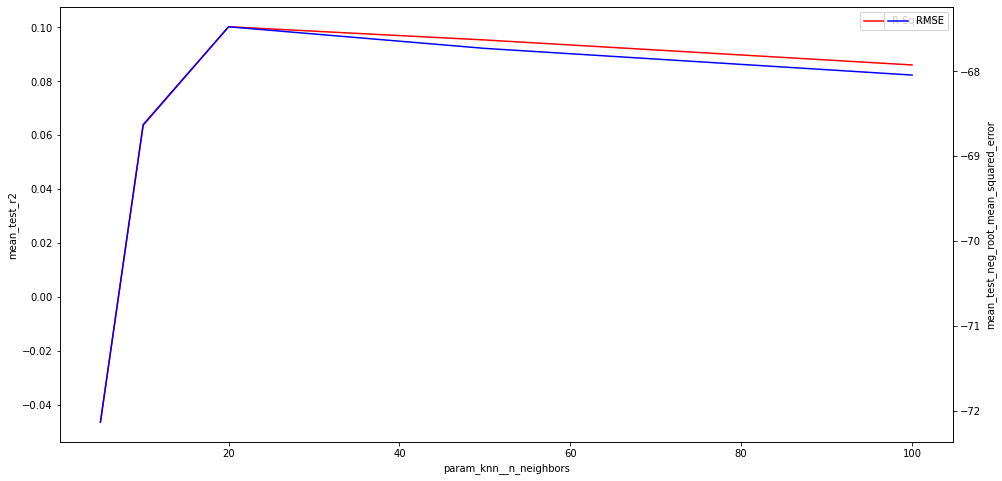

In [87]:
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x='param_knn__n_neighbors', y="mean_test_r2", data=uniform_results, color='red', label = 'R-Squared')
ax2=ax.twinx()
sns.lineplot(x='param_knn__n_neighbors', y="mean_test_neg_root_mean_squared_error", data=uniform_results, color='blue', label = 'RMSE')
plt.legend()

Here we can see that R-Squared increases quickly until about k=20, then the values begin to decrease.  RMSE shows a similar pattern.

### Graph Metrics for Distance Models

<AxesSubplot:label='372b994f-d3ff-4588-a9f1-f33239ed4f27', xlabel='param_knn__n_neighbors', ylabel='mean_test_neg_root_mean_squared_error'>

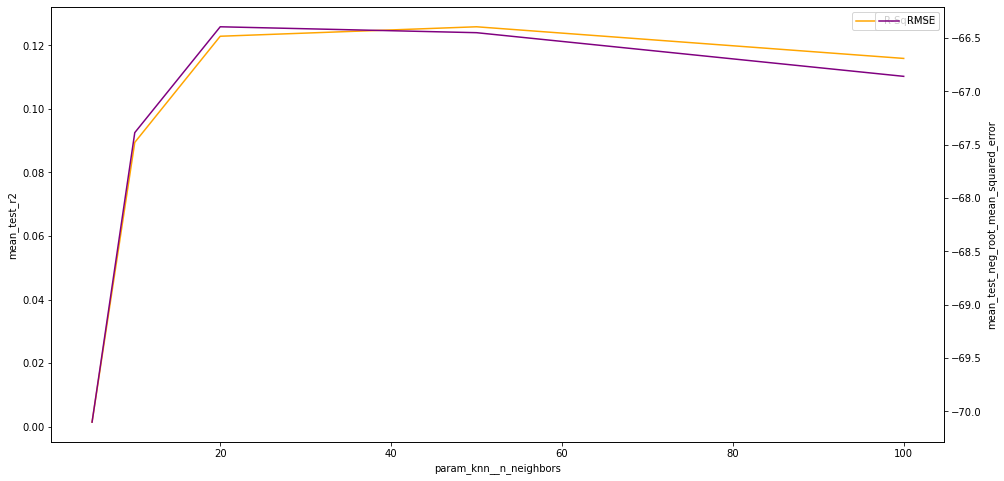

In [88]:
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x='param_knn__n_neighbors', y="mean_test_r2", data=distance_results, color='orange', label = 'R-Squared')
ax2=ax.twinx()
sns.lineplot(x='param_knn__n_neighbors', y="mean_test_neg_root_mean_squared_error", data=distance_results, color='purple', label = 'RMSE')

Here we can see that R-Squared increases quickly until about k=20, then less rapidly through k=50 or so.  Then the values begin to decrease.  RMSE shows a similar pattern.

Now we look at the mean R-Squared values for distance vs uniform weight functions.  Below we can see that for any given number of nearest neighbors k, the distance weight function performs better.  We'll tune our model again using a distance weights and more targeted k values based on the above graphs.

In [89]:
distance_results[['mean_test_r2']]

,mean_test_r2
9,0.115881
7,0.125837
5,0.122857
3,0.089463
1,0.001435


In [90]:
uniform_results[['mean_test_r2']]

,mean_test_r2
8,0.086082
6,0.095358
4,0.100256
2,0.063654
0,-0.046531


# 2nd Tuned KNN Model

In [91]:
# Create the grid parameter using neighbor values based on our previous graphs.
grid_knn_2 = [{'knn__n_neighbors': [30, 40, 50, 60, 70], 
              'knn__weights': ['distance']}]

# Create the grid, with "pipe" as the estimator
gridsearch_knn_2 = GridSearchCV(estimator=pipe_knn, 
                          param_grid=grid_knn_2, 
                          scoring=['r2', 'neg_root_mean_squared_error'], 
                          refit='r2',
                          cv=5,
                          n_jobs=-1)

In [92]:
gridsearch_knn_2.fit(X_train_ohe, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('pca', PCA(n_components=0.9)),
                                       ('knn',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'knn__n_neighbors': [30, 40, 50, 60, 70],
                          'knn__weights': ['distance']}],
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [93]:
#Save the model
dump(gridsearch_knn_2, 'gridsearch_knn_2.joblib') 

['gridsearch_knn_2.joblib']

In [94]:
gridsearch_knn_2.best_params_

{'knn__n_neighbors': 30, 'knn__weights': 'distance'}

In [95]:
gridsearch_knn_2.best_score_

0.1307760156344741

In [96]:
gridsearch_knn_df2 = pd.DataFrame.from_dict(gridsearch_knn_2.cv_results_)
gridsearch_knn_df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_r2,split1_test_r2,split2_test_r2,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,88.094349,17.298172,101.715372,18.242396,30,distance,"{'knn__n_neighbors': 30, 'knn__weights': 'dist...",0.162473,0.113972,0.110030,...,0.018636,1,-81.933344,-67.688232,-60.506095,-66.105800,-54.770724,-66.200839,9.086371,1
1,113.544766,10.209081,113.961914,22.678186,40,distance,"{'knn__n_neighbors': 40, 'knn__weights': 'dist...",0.147408,0.115425,0.106944,...,0.015138,2,-82.666978,-67.632711,-60.610897,-66.163183,-54.542355,-66.323225,9.383797,2
2,99.105756,9.053153,145.190903,3.576614,50,distance,"{'knn__n_neighbors': 50, 'knn__weights': 'dist...",0.137240,0.114089,0.107293,...,0.012932,3,-83.158432,-67.683764,-60.599069,-66.265558,-54.538341,-66.449033,9.558754,3
3,128.544312,21.092029,133.932774,27.783990,60,distance,"{'knn__n_neighbors': 60, 'knn__weights': 'dist...",0.133860,0.111045,0.103980,...,0.014561,4,-83.321153,-67.799928,-60.711417,-66.413899,-54.423360,-66.533952,9.633230,4
4,125.881806,21.276147,137.298022,56.974928,70,distance,"{'knn__n_neighbors': 70, 'knn__weights': 'dist...",0.126118,0.109275,0.098608,...,0.014753,5,-83.692720,-67.867407,-60.893141,-66.565431,-54.485830,-66.700906,9.726655,5


Our 2nd iteration of tuning the KNN model results in our best model using 30 nearest neighbors with a distance weighting function.  This model is better than our previous best with R-Squared of 13.1% and RMSE of 66.2 vs previous R-Squared of 12.6% and RMSE of 66.4.

In [97]:
gridsearch_knn_df2['mean_test_r2'][0]

0.1307760156344741

In [98]:
gridsearch_knn_df2['mean_test_neg_root_mean_squared_error'][0]

-66.2008390626158

In [99]:
gridsearch_knn_df[['mean_test_r2', 'mean_test_neg_root_mean_squared_error']]

,mean_test_r2,mean_test_neg_root_mean_squared_error
0,-0.046531,-72.130892
1,0.001435,-70.100076
2,0.063654,-68.627431
3,0.089463,-67.385914
4,0.100256,-67.475206
5,0.122857,-66.393671
6,0.095358,-67.729646
7,0.125837,-66.449033
8,0.086082,-68.043727
9,0.115881,-66.858341


We have tuned our KNN model, but the R-Squared metric still is not as high as we might like.  About 13% of the variation in revenue can be explained by our tuned model.  The KNN model is limited both by our computational resources and by how KNN performs when there are many dimensions and many rows.

Additionally, we want to analyze which features are most important in predicting how much a customer spends.  This is not possible with a KNN model.  

Tree-based models do have this functionality.  Our next step is to implement a decision tree regressor.  Once we have a sufficient tree-based model, we will examine the Gini Importance of different features to make conclusions about online shopping at Google's store.

# Decision Tree Model

In tuning this model we need to use a RandomizedSearchCV because our computational resources are limited.  We will tune based on a random selection from the starting hyperparameters, then look for patterns and tune again from there.

In [16]:
#Create pipeline
pipe_tree = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.9)),
            ('tree', DecisionTreeRegressor(random_state=70))])

In [17]:
# Create the grid parameter
grid_tree = [{'tree__max_depth': [10, 20, 35, 50], 
             'tree__min_samples_split': [5, 10, 30, 40, 50],
             'tree__min_samples_leaf': [10, 30, 100, 300],
             'tree__criterion': ['mse'],
             'tree__max_features': [None, 'sqrt', 'log2']
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_tree = RandomizedSearchCV(estimator=pipe_tree, 
                          param_distributions=grid_tree, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          cv=5,
                          n_iter=15,
                          n_jobs=-1,
                          verbose=8)

In [18]:
gridsearch_tree.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed: 17.7min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 19.1min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('pca', PCA(n_components=0.9)),
                                             ('tree',
                                              DecisionTreeRegressor(random_state=70))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'tree__criterion': ['mse'],
                                         'tree__max_depth': [10, 20, 35, 50],
                                         'tree__max_features': [None, 'sqrt',
                                                                'log2'],
                                         'tree__min_samples_leaf': [10, 30, 100,
                                                                    300],
                                         'tree__min_samples_split': [5, 10, 30,
                                                                     40, 50]}],
                   refit='r2'

In [60]:
#Save the model
dump(gridsearch_tree, 'gridsearch_tree.joblib') 

['gridsearch_tree.joblib']

In [21]:
gridsearch_tree.best_params_

{'tree__min_samples_split': 50,
 'tree__min_samples_leaf': 30,
 'tree__max_features': None,
 'tree__max_depth': 10,
 'tree__criterion': 'mse'}

The best R-Squared score from this model is 8.6%.  This is lower than our tuned KNN model, but high enough to continue iterating with tree-based models.  A random forest model may be more effective than a single decision tree.

In [22]:
gridsearch_tree.best_score_

0.08593649123624995

In [24]:
gridsearch_tree_df = pd.DataFrame.from_dict(gridsearch_tree.cv_results_)
gridsearch_tree_df.loc[gridsearch_tree_df['rank_test_r2'] < 6]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__min_samples_split,param_tree__min_samples_leaf,param_tree__max_features,param_tree__max_depth,param_tree__criterion,params,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
6,84.608612,9.707482,6.210377,1.502562,50,100,log2,10,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.015772,5,-86.582035,-69.502612,-61.726951,-67.327202,-55.903973,-68.208555,10.329086,6
7,178.413115,9.101852,4.666100,0.209530,50,30,None,10,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.017522,1,-84.386796,-68.337727,-61.919314,-67.862211,-56.863729,-67.873955,9.269002,1
8,217.496099,11.545997,4.767680,0.528180,5,100,None,20,mse,"{'tree__min_samples_split': 5, 'tree__min_samp...",...,0.007800,3,-85.796761,-68.706170,-61.507549,-67.440552,-56.494466,-67.989100,9.920332,3
13,212.562081,16.824093,4.036405,0.447493,40,100,None,50,mse,"{'tree__min_samples_split': 40, 'tree__min_sam...",...,0.007800,2,-85.796720,-68.706170,-61.507571,-67.440555,-56.494466,-67.989096,9.920315,2
14,165.105033,42.882446,2.617595,0.725113,50,30,None,20,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.017682,4,-84.619476,-68.493799,-62.154031,-68.082234,-56.960312,-68.061970,9.300413,4


Here we can see that our 'best' parameters in terms of R-Squared also achieve the lowest RMSE.

Other trends to note:
* min_samples_split is generally at the higher end of the possible range for the highest ranked hyperparameters.
* max_features is None for most of the highest ranked hyperparameters
* max_depth is mostly in the 10-20 range.
* min_samples_leaf is 30 or 100 for each of the top 5 ranked models.

Next we will use this information to tailor our list of possible hyperparameters and tune again.

# 2nd Iteration - Tuned Decision Tree Model

Here we adjust the grid parameters based on the results of the first model.

In [25]:
# Create the grid parameter
grid_tree2 = [{'tree__max_depth': [10, 15, 20, 25, 30], 
             'tree__min_samples_split': [40, 50, 60, 70, 100],
             'tree__min_samples_leaf': [25, 40, 50, 50, 75, 100],
             'tree__criterion': ['mse'],
             'tree__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_tree2 = RandomizedSearchCV(estimator=pipe_tree, 
                          param_distributions=grid_tree2, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          cv=5,
                          n_iter=15,
                          n_jobs=-1,
                          verbose=8)

In [26]:
gridsearch_tree2.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  70 out of  75 | elapsed: 18.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 19.5min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('pca', PCA(n_components=0.9)),
                                             ('tree',
                                              DecisionTreeRegressor(random_state=70))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'tree__criterion': ['mse'],
                                         'tree__max_depth': [10, 15, 20, 25,
                                                             30],
                                         'tree__max_features': [None],
                                         'tree__min_samples_leaf': [25, 40, 50,
                                                                    50, 75,
                                                                    100],
                                         'tree__min_samples_split': [40, 50, 60,
                                                

In [59]:
#Save the model
dump(gridsearch_tree2, 'gridsearch_tree2.joblib') 

['gridsearch_tree2.joblib']

In [27]:
gridsearch_tree2.best_params_

{'tree__min_samples_split': 50,
 'tree__min_samples_leaf': 25,
 'tree__max_features': None,
 'tree__max_depth': 10,
 'tree__criterion': 'mse'}

The score has improved, but is still not at the same level as the KNN model.

In [28]:
gridsearch_tree2.best_score_

0.10214052833658269

In [29]:
gridsearch_tree_df2 = pd.DataFrame.from_dict(gridsearch_tree2.cv_results_)
gridsearch_tree_df2.loc[gridsearch_tree_df2['rank_test_r2'] < 6]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__min_samples_split,param_tree__min_samples_leaf,param_tree__max_features,param_tree__max_depth,param_tree__criterion,params,...,std_test_r2,rank_test_r2,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,160.721360,0.866581,2.789838,0.067428,100,25,None,15,mse,"{'tree__min_samples_split': 100, 'tree__min_sa...",...,0.025763,5,-84.423167,-68.323677,-60.949473,-67.625181,-57.712221,-67.806744,9.223093,5
1,150.488482,16.630706,2.791974,0.149412,50,75,None,25,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.013869,2,-85.203881,-68.827723,-61.501614,-66.864987,-56.544852,-67.788611,9.707450,2
7,116.154980,14.068190,2.832764,0.216005,100,75,None,30,mse,"{'tree__min_samples_split': 100, 'tree__min_sa...",...,0.013869,2,-85.203881,-68.827723,-61.501614,-66.864987,-56.544852,-67.788611,9.707450,2
8,81.416739,1.667214,2.990481,0.345178,50,25,None,10,mse,"{'tree__min_samples_split': 50, 'tree__min_sam...",...,0.047372,1,-80.948403,-68.371313,-60.770486,-67.554064,-57.815141,-67.091881,7.998396,1
13,100.158337,3.901560,2.630342,0.475071,40,75,None,15,mse,"{'tree__min_samples_split': 40, 'tree__min_sam...",...,0.013892,4,-85.194629,-68.840183,-61.501646,-66.864986,-56.541874,-67.788663,9.705085,4


The best decision tree model has an R-Squared of 10.2%.  It also has the best RMSE (67.1) of the models we tested.  This is not as accurate as the tuned KNN model, but it gives us the insight that tree-based models could be useful in modeling our data.  

Based on this insight we can move on to use a Random Forest Regressor.  This model will aggregate many different Decision Trees, thus creating a more robust model that is less prone to overfitting.

# Random Forest Model

We start with a wide range of parameters.  This will give us a good starting point, and we can further tune the model in the next iteration.

In [46]:
#Create pipeline
pipe_forest = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.85)),
            ('forest', RandomForestRegressor(random_state=70, n_jobs=-1, warm_start=True))])

In [48]:
# Create the grid parameter

#fewer values in larger range

grid_forest = [{'forest__n_estimators': [50, 100, 150], #~100
             'forest__max_depth': [1, 15, 50], 
             'forest__min_samples_split': [5, 25, 50], #try lowering
             'forest__min_samples_leaf': [5, 25, 50], #try lowering
             'forest__criterion': ['mse'],
             'forest__max_features': [None],
#              'forest__min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4], #more subtle
#              'forest__oob_score': [False, True]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest = RandomizedSearchCV(estimator=pipe_forest, 
                          param_distributions=grid_forest, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_iter=5, #Try 15 hyperparameter combinations
                          n_jobs=-1, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [49]:
gridsearch_forest.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed: 64.6min remaining: 50.7min
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed: 143.7min remaining: 55.9min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed: 173.7min remaining: 23.7min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 176.0min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('pca', PCA(n_components=0.85)),
                                             ('forest',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=70,
                                                                    warm_start=True))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'forest__criterion': ['mse'],
                                         'forest__max_depth': [1, 15, 50],
                                         'forest__max_features': [None],
                                         'forest__min_samples_leaf': [5, 25,
                                                                      50],
                                         'forest__min_samples_split': [5, 25,
                           

In [50]:
gridsearch_forest.best_params_

{'forest__n_estimators': 100,
 'forest__min_samples_split': 25,
 'forest__min_samples_leaf': 50,
 'forest__max_features': None,
 'forest__max_depth': 15,
 'forest__criterion': 'mse'}

In [51]:
gridsearch_forest.best_score_

0.11946150306035266

Our best model had hyperparameters that were in the middle ranges of our gridsearch.  Additionally, our result improved on the R-Squared score from our Decision Tree.  Now we will take a look at our best RF models so that we can decide how to proceed.

In [58]:
#Save the model
dump(gridsearch_forest, 'gridsearch_forest.joblib') 

['gridsearch_forest.joblib']

Now take a look at our top performing models.

In [54]:
gridsearch_forest_df = pd.DataFrame.from_dict(gridsearch_forest.cv_results_)
best_models = gridsearch_forest_df.loc[gridsearch_forest_df['rank_test_r2'] < 6]

In [57]:
best_models[['params', 'rank_test_r2','mean_test_r2', 'mean_train_r2', 'rank_test_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error']]

,params,rank_test_r2,mean_test_r2,mean_train_r2,rank_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
0,"{'forest__n_estimators': 50, 'forest__min_samp...",5,0.044957,0.044415,5,-69.520763,-70.181720
1,"{'forest__n_estimators': 50, 'forest__min_samp...",2,0.118616,0.162620,2,-66.787437,-65.700502
2,"{'forest__n_estimators': 150, 'forest__min_sam...",3,0.088677,0.328945,3,-67.685725,-58.832197
3,"{'forest__n_estimators': 100, 'forest__min_sam...",4,0.046769,0.046580,4,-69.461542,-70.100726
4,"{'forest__n_estimators': 100, 'forest__min_sam...",1,0.119462,0.163623,1,-66.762830,-65.659199


Comparison between the mean train and mean test scores in the table above shows us that our model is overfitting to the training data a bit.  We'll keep this in mind when coming up with the parameters for our next iteration of tuning the model.

In [62]:
best_models['params'][4]

{'forest__n_estimators': 100,
 'forest__min_samples_split': 25,
 'forest__min_samples_leaf': 50,
 'forest__max_features': None,
 'forest__max_depth': 15,
 'forest__criterion': 'mse'}

In [63]:
best_models['params'][1]

{'forest__n_estimators': 50,
 'forest__min_samples_split': 25,
 'forest__min_samples_leaf': 50,
 'forest__max_features': None,
 'forest__max_depth': 50,
 'forest__criterion': 'mse'}

Our 2 best models had scores far above our other models.  We'll use the parameters for these models to narrow in on our choices for our next iteration.
*  'min_samples_split': 25
*  'min_samples_leaf': 50
*  'n_estimators' between 50-100
*  'max_depth between 15 and 50

# 2nd Random Forest Model

Here we tune another iteration of a Random Forest model.  We use values in a closer range around the successful values from the previous top-ranked models.  Additionally we consider using higher min_samples parameters to prune the tree and prevent overfitting to the training data.

In [65]:
# Create the grid parameter
grid_forest2 = [{'forest__n_estimators': [60, 80, 100], 
             'forest__max_depth': [15, 25, 40, 50], 
             'forest__min_samples_split': [20, 25, 30], 
             'forest__min_samples_leaf': [40, 50, 60],
             'forest__criterion': ['mse'],
             'forest__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest2 = RandomizedSearchCV(estimator=pipe_forest, 
                          param_distributions=grid_forest2, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_iter=5, #Try 5 hyperparameter combinations
                          n_jobs=-1, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [66]:
gridsearch_forest2.fit(X_train_ohe, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed: 135.0min remaining: 106.1min
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed: 175.1min remaining: 68.1min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed: 183.9min remaining: 25.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 188.0min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('pca', PCA(n_components=0.85)),
                                             ('forest',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=70,
                                                                    warm_start=True))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'forest__criterion': ['mse'],
                                         'forest__max_depth': [15, 25, 40, 50],
                                         'forest__max_features': [None],
                                         'forest__min_samples_leaf': [40, 50,
                                                                      60],
                                         'forest__min_samples_split': [20, 25,
                    

In [67]:
gridsearch_forest2.best_params_

{'forest__n_estimators': 60,
 'forest__min_samples_split': 30,
 'forest__min_samples_leaf': 40,
 'forest__max_features': None,
 'forest__max_depth': 40,
 'forest__criterion': 'mse'}

In [68]:
gridsearch_forest2.best_score_

0.12322398250039837

We've further tuned our model, however the gain to R-Squared is fairly minimal (from 11.9% to 12.3%).  

In [69]:
#Save the model
dump(gridsearch_forest2, 'gridsearch_forest2.joblib') 

['gridsearch_forest2.joblib']

Our top model in terms of R-Squared also has the best RMSE (66.6).  The gains in performance using tree-based models are slowing, so it may be time to try a different flavor of model.

In [72]:
gridsearch_forest_df2 = pd.DataFrame.from_dict(gridsearch_forest2.cv_results_)
best_models2 = gridsearch_forest_df2.loc[gridsearch_forest_df2['rank_test_r2'] < 6]
best_models2[['params', 'rank_test_r2','mean_test_r2', 'mean_train_r2', 'rank_test_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error']]

,params,rank_test_r2,mean_test_r2,mean_train_r2,rank_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
0,"{'forest__n_estimators': 60, 'forest__min_samp...",5,0.117283,0.153755,5,-66.858877,-66.047053
1,"{'forest__n_estimators': 80, 'forest__min_samp...",2,0.122513,0.176656,2,-66.625240,-65.144953
2,"{'forest__n_estimators': 60, 'forest__min_samp...",3,0.119174,0.162719,3,-66.769854,-65.695607
3,"{'forest__n_estimators': 60, 'forest__min_samp...",1,0.123224,0.175657,1,-66.596075,-65.185283
4,"{'forest__n_estimators': 60, 'forest__min_samp...",4,0.117283,0.153755,4,-66.858877,-66.047053


# Feature Engineering - From Original Data

More explanatory variables are needed in order to improve our models.  First we'll pull in additional data relating to page hits and the customer's location from our data source.  This new data is saved in data3.csv.  Preprocessing on this data is shown in the Preprocessing_additional_data.ipynb notebook.

### Pull in Additional Data

In [2]:
df2 = pd.read_csv('../Data/data3.csv', dtype={'fullVisitorId': 'str'})
df2.drop('Unnamed: 0', axis=1, inplace=True)
df2.info()

/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (66,76,84,85,93) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Columns: 123 entries, Unnamed: 0.1 to visitNumber
dtypes: bool(2), float64(3), int64(10), object(108)
memory usage: 663.5+ MB


Since we are only using data from the USA in this analysis, most of the geoNetwork data is not useful.  We'll drop it here but keep the networkDomain column.  Then group together the most unique values so that the column will be usable in the modeling.

In [3]:
df2.drop(['geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country'], axis=1, inplace=True)

In [4]:
top_net_domain = list(df2['geoNetwork.networkDomain'].value_counts().head(31).index)
df2['geoNetwork.networkDomain'] = df2['geoNetwork.networkDomain'].apply(lambda x: x if x in top_net_domain else 'Other')
df2['geoNetwork.networkDomain'].replace('(not set)', 'None', inplace=True)
df2['geoNetwork.networkDomain'].value_counts()

None                   360315
Other                   92205
comcast.net             55484
unknown.unknown         36636
rr.com                  28708
verizon.net             26545
comcastbusiness.net     16826
cox.net                 10721
sbcglobal.net           10596
optonline.net            9734
google.com               9621
att.net                  9255
qwest.net                6940
bhn.net                  5361
spcsdns.net              4684
amazonaws.com            3566
myvzw.com                2827
com                      2486
mycingular.net           2441
suddenlink.net           2421
windstream.net           2399
cogentco.com             2381
rcn.com                  1990
ztomy.com                1936
frontiernet.net          1867
embarqhsd.net            1568
telepacific.net          1568
mchsi.com                1420
wideopenwest.com         1414
twtelecom.net            1130
telia.net                1093
wayport.net              1079
Name: geoNetwork.networkDomain, dtype: i

In [5]:
# Filter df for modeling
dfm2 = df2.copy()
dfm2.drop(['time', 'totals.totalTransactionRevenue', 'totals.transactionRevenue', 'date', 'fullVisitorId', 'visitId', 'total_revenue_usd', 'totals.transactions', 'purchase'], axis=1, inplace=True)
dfm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Columns: 111 entries, Unnamed: 0.1 to visitNumber
dtypes: bool(1), float64(2), int64(6), object(102)
memory usage: 602.6+ MB


In [6]:
dfm2.head()

,Unnamed: 0.1,channelGrouping,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.networkDomain,hits_action_type,hits_affiliation,hits_contentGroup1,...,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitNumber
0,0,Referral,Chrome,desktop,False,Chrome OS,None,"['0', '0']",NaN,"['(not set)', '(not set)']",...,Other,None,0.0,None,None,Other,referral,Other,sites.google.com,6
1,1,Direct,Chrome,mobile,True,Android,Other,"['0', '0']",NaN,"['(not set)', '(not set)']",...,Other,None,0.0,None,None,Other,None,Other,(direct),1
2,2,Referral,Chrome,desktop,False,Macintosh,unknown.unknown,"['0', '0']",NaN,"['(not set)', '(not set)']",...,Other,None,0.0,None,None,Other,None,/offer/2145,(direct),1
3,3,Organic Search,Safari,mobile,True,iOS,bhn.net,"['0', '0']",NaN,"['(not set)', '(not set)']",...,Other,None,0.0,None,None,None,organic,Other,google,1
4,4,Paid Search,Safari,mobile,True,iOS,att.net,"['0', '0']",NaN,"['(not set)', '(not set)']",...,Other,None,0.0,None,Other,(Remarketing/Content targeting),cpc,Other,google,10


### Extract Features from 'Hits' Columns

The hits column contains a large number of features, many of which are not in a format suitable for modeling.  Extract useful features relating to the most recent page visits:

#### Get Product Subcategory of Last Viewed Item

In [7]:
dfm2['hits_v2ProductCategory'].fillna("'None'", inplace=True)

In [8]:
dfm2['product_category'] = dfm2['hits_v2ProductCategory'].apply(lambda x: str(x).split("'")[1])

In [9]:
dfm2['product_category'].replace("(not set)", "None", inplace=True)

In [10]:
dfm2['product_category'] = dfm2['product_category'].apply(lambda x: str(x).split("/")[1] if "/" in str(x) else str(x))

In [11]:
top_prod_cats = list(dfm2['product_category'].value_counts().head(14).index)
dfm2['product_category'] = dfm2['product_category'].apply(lambda x: x if x in top_prod_cats else 'Other')
dfm2['product_category'].value_counts()

None              336406
Apparel           149446
Shop by Brand      89570
Bags               31818
Accessories        27640
Electronics        27332
Drinkware          25017
Office             18625
TYCTWD 2018         3133
Other               2203
${escCatTitle}      1302
Limited Supply      1296
Lifestyle           1274
Gift Cards          1173
Clearance Sale       982
Name: product_category, dtype: int64

#### Get Price of Last Viewed Item

In [12]:
dfm2['hits_productPrice'].fillna("'0'", inplace=True)

In [13]:
dfm2['product_price'] = dfm2['hits_productPrice'].apply(lambda x: str(x).split("'")[1])

In [14]:
dfm2['product_price'] = dfm2['product_price'].astype(int)
dfm2['product_price'] = dfm2['product_price'] / (10**6)

## Drop Unneeded 'Hits' Columns

In [15]:
unused_hits = []
for col in dfm2.columns:
    if 'hits_' in col:
        unused_hits.append(col)
dfm2.drop(unused_hits, axis=1, inplace=True)

In [16]:
dfm2.drop('Unnamed: 0.1', axis=1, inplace=True)
dfm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 24 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   device.browser                                717217 non-null  object 
 2   device.deviceCategory                         717217 non-null  object 
 3   device.isMobile                               717217 non-null  bool   
 4   device.operatingSystem                        717217 non-null  object 
 5   geoNetwork.networkDomain                      717217 non-null  object 
 6   revenue_usd                                   717217 non-null  float64
 7   time_of_day                                   717217 non-null  object 
 8   totals.hits                                   717217 non-null  int64  
 9   totals.pageviews                              71

Save the updated data for easier access when re-running the notebook.

In [17]:
dfm2.to_csv('../Data/data4.csv')

# Feature Engineering - K Means Clustering

Clustering is another method we can use to add explanatory variables to our model.  Here we use K Means clustering to group our data into clusters.  Once finished, we will add the cluster labels and silhouette scores to our data as additional columns.  Then we will re-run the tuned Random Forest model.

## Train Test Split

To prevent leakage from test data, we will split into train and test sets before clustering.  When we test our final model we will add a separate clustering column to the test data.

In [4]:
dfm2 = pd.read_csv('../Data/data4.csv')
dfm2.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
X = dfm2.drop('revenue_usd', axis=1)
Y = dfm2['revenue_usd']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=70)

Creating dummy variables with get_dummies.  get_dummies does not drop any categorical columns.  This is not a problem for the models we have used so far, but would need to be updated for models like linear regression.

In [7]:
X_train_ohe = pd.get_dummies(X_train)
X_train_ohe.head()

,device.isMobile,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,trafficSource.adwordsClickInfo.page,visitNumber,product_price,channelGrouping_(Other),channelGrouping_Affiliates,...,product_category_Drinkware,product_category_Electronics,product_category_Gift Cards,product_category_Lifestyle,product_category_Limited Supply,product_category_None,product_category_Office,product_category_Other,product_category_Shop by Brand,product_category_TYCTWD 2018
678941,False,9,7,2,101,0.0,1,1.99,0,0,...,0,0,0,0,0,0,1,0,0,0
561021,False,11,7,31,111,0.0,5,74.99,0,0,...,0,0,0,0,0,0,0,0,0,0
153899,False,9,7,-1,115,0.0,2,34.99,0,0,...,0,1,0,0,0,0,0,0,0,0
54930,False,4,4,-1,64,0.0,1,16.99,0,0,...,0,0,0,0,0,0,0,0,1,0
628845,False,48,28,70,228,0.0,33,18.99,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clustering

Because of limits on computational resources, we scale and do PCA before clustering.  This will decrease multidimensionality and reduce the computer power needed to cluster.

In [53]:
#Create pipeline to reduce data dimensionality
pipe_reduce = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.75, random_state=70))])

In [ ]:
X_train_reduced = pipe_reduce.fit_transform(X_train_ohe)

Check that dimensionality was reduced & number of samples remained the same.

In [55]:
X_train_ohe.shape

(573773, 181)

In [56]:
X_train_reduced.shape

(573773, 78)

Search through a list of values to find the best k value for the KMeans algorithm.  We use the inertia-based elbow method and silhouette scores to decide which k value is 'best'.

In [58]:
distortions = []
silhouette_plot = []
ch_score = []
k_values = [3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50,55, 60, 65,70, 75,80, 90, 100, 150, 200, 250, 300, 500]
for k in tqdm(k_values):
    #Create KMeans model object
    clusters = KMeans(n_clusters=k, random_state=70, n_jobs=-1, algorithm='full')
    print("Model Created with k=" + str(k))
    
    #Fit model.
    cluster_fit = clusters.fit(X_train_reduced)
    print("Model Fit Complete")
    
    #Get predictions for use in silhouette score calculations
    cluster_labels = cluster_fit.predict(X_train_reduced)
    print("Predictions from Model Complete")
    silhouette_avg = silhouette_score(X_train_ohe, cluster_labels, sample_size=2500, random_state=70)
    silhouette_plot.append(silhouette_avg)
    ch_score.append(calinski_harabasz_score(X_train_reduced, cluster_fit.labels_))
    
    #Get inertia value for use in elbow plot
    distortions.append(cluster_fit.inertia_)
    print("Loop Complete for k=" + str(k) + " Model")

  0%|          | 0/24 [00:00<?, ?it/s]

Model Created with k=3


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


  4%|▍         | 1/24 [00:14<05:36, 14.62s/it]

Loop Complete for k=3 Model
Model Created with k=5


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


  8%|▊         | 2/24 [00:30<05:30, 15.03s/it]

Loop Complete for k=5 Model
Model Created with k=10


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 12%|█▎        | 3/24 [00:51<05:50, 16.70s/it]

Loop Complete for k=10 Model
Model Created with k=15


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 17%|█▋        | 4/24 [01:16<06:23, 19.16s/it]

Loop Complete for k=15 Model
Model Created with k=20


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 21%|██        | 5/24 [01:45<07:02, 22.24s/it]

Loop Complete for k=20 Model
Model Created with k=25


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 25%|██▌       | 6/24 [02:20<07:50, 26.14s/it]

Loop Complete for k=25 Model
Model Created with k=30


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 29%|██▉       | 7/24 [03:02<08:43, 30.78s/it]

Loop Complete for k=30 Model
Model Created with k=35


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 33%|███▎      | 8/24 [03:48<09:28, 35.53s/it]

Loop Complete for k=35 Model
Model Created with k=40


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 38%|███▊      | 9/24 [04:40<10:06, 40.41s/it]

Loop Complete for k=40 Model
Model Created with k=45


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 42%|████▏     | 10/24 [05:38<10:39, 45.65s/it]

Loop Complete for k=45 Model
Model Created with k=50


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 46%|████▌     | 11/24 [06:44<11:11, 51.65s/it]

Loop Complete for k=50 Model
Model Created with k=55


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 50%|█████     | 12/24 [07:57<11:38, 58.17s/it]

Loop Complete for k=55 Model
Model Created with k=60


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 54%|█████▍    | 13/24 [09:16<11:47, 64.35s/it]

Loop Complete for k=60 Model
Model Created with k=65


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 58%|█████▊    | 14/24 [10:43<11:50, 71.03s/it]

Loop Complete for k=65 Model
Model Created with k=70


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 62%|██████▎   | 15/24 [12:23<11:57, 79.73s/it]

Loop Complete for k=70 Model
Model Created with k=75


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 67%|██████▋   | 16/24 [14:12<11:48, 88.52s/it]

Loop Complete for k=75 Model
Model Created with k=80


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 71%|███████   | 17/24 [16:00<11:00, 94.36s/it]

Loop Complete for k=80 Model
Model Created with k=90


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 75%|███████▌  | 18/24 [18:00<10:12, 102.06s/it]

Loop Complete for k=90 Model
Model Created with k=100


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 79%|███████▉  | 19/24 [20:14<09:19, 111.81s/it]

Loop Complete for k=100 Model
Model Created with k=150


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 83%|████████▎ | 20/24 [23:39<09:19, 139.76s/it]

Loop Complete for k=150 Model
Model Created with k=200


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 88%|████████▊ | 21/24 [28:07<08:54, 178.21s/it]

Loop Complete for k=200 Model
Model Created with k=250


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 92%|█████████▏| 22/24 [33:59<07:40, 230.17s/it]

Loop Complete for k=250 Model
Model Created with k=300


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


 96%|█████████▌| 23/24 [40:38<04:41, 281.06s/it]

Loop Complete for k=300 Model
Model Created with k=500


/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Model Fit Complete
Predictions from Model Complete


100%|██████████| 24/24 [53:37<00:00, 134.07s/it]

Loop Complete for k=500 Model


Now we plot the inertia values in an elbow plot.

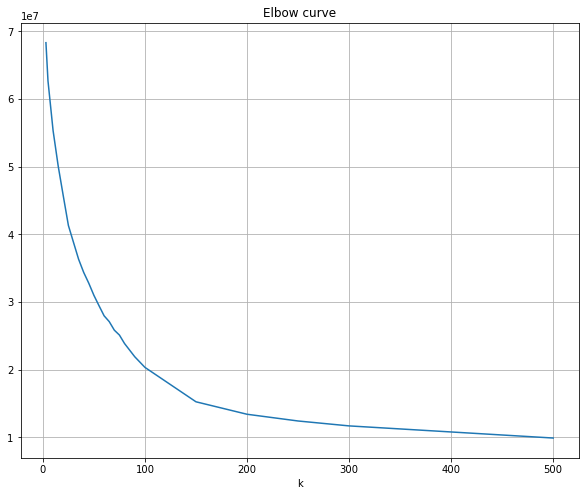

In [62]:
# Plot Inertia Values
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Elbow curve')
ax.set_xlabel('k')
ax.plot(k_values, distortions)
ax.grid(True)

Next we graph how the silhouette score changes with different values of k.

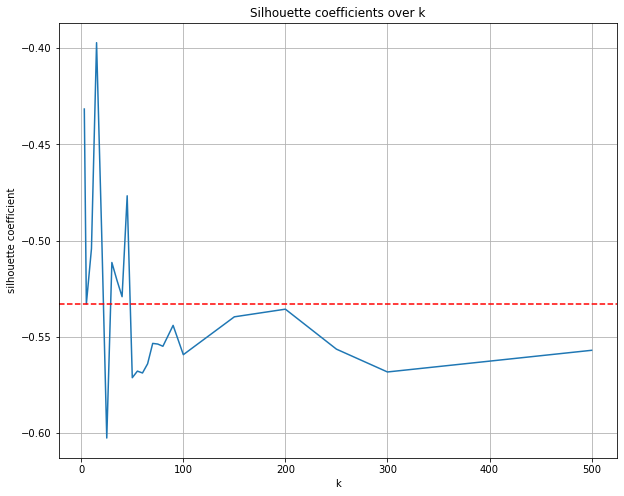

In [65]:
# Plot Silhouette coefficient
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Silhouette coefficients over k')
ax.set_xlabel('k')
ax.set_ylabel('silhouette coefficient')
ax.plot(k_values, silhouette_plot)
ax.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
ax.grid(True)

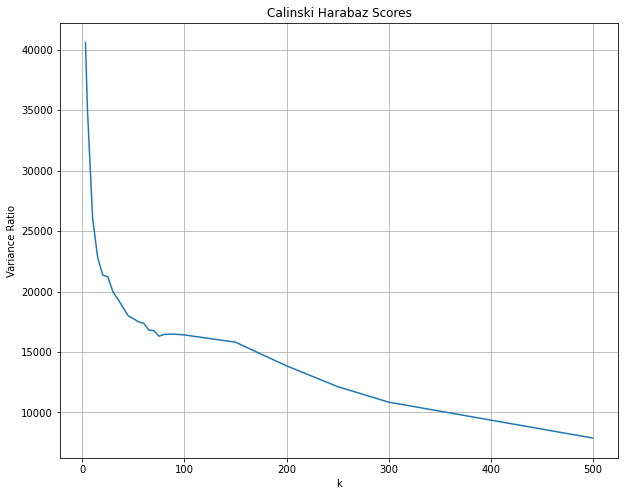

In [66]:
# Plot CH Score Values
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Calinski Harabaz Scores')
ax.set_xlabel('k')
ax.set_ylabel('Variance Ratio')
ax.plot(k_values, ch_score)
ax.grid(True)

A k value of 100 is a good tradeoff between the results of our various scoring metrics.  The CH score is near an inflection point before it begins to trail off.  The silhouette score is close to the average score.  Also, the inertia (which should be minimized) reaches an 'elbow' at k = ~100.  

The average silhouette score is negative, so our clusters are likely not well defined, however the results from our clustering may still add useful features to use in the KNN Regression.

In [24]:
#Create best model
best_cluster = KMeans(n_clusters=100, random_state=70, n_jobs=-1, algorithm='full')

#Fit model.
best_cluster_fit = best_cluster.fit(X_train_reduced)

#Get labels for use in silhouette score calculations
best_cluster_labels = best_cluster_fit.predict(X_train_reduced)

sil_scores = silhouette_samples(X_train_reduced, best_cluster_labels)

/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [30]:
sil_scores.shape

(573773,)

In [31]:
best_cluster_labels.shape

(573773,)

In [32]:
#Save the silhouette scores
dump(sil_scores, 'sil_scores_kmeans.joblib') 

#Save the model
dump(best_cluster_fit, 'kmeans_100_fit.joblib')

#Save the predictions
dump(best_cluster_labels, 'kmeans_100_labels.joblib')

['kmeans_100_labels.joblib']

## Merge New Features with Data

In [8]:
sil_scores = load('sil_scores_kmeans.joblib')
best_cluster_fit = load('kmeans_100_fit.joblib')
best_cluster_labels = load('kmeans_100_labels.joblib')

Change clustering results to Pandas Series objects for concatenation with main data set.

In [9]:
sil_scores = pd.Series(sil_scores, name='sil_score')
sil_scores.shape

(573773,)

In [10]:
best_cluster_labels = pd.Series(best_cluster_labels, name='cluster_label')
best_cluster_labels.shape

(573773,)

In [11]:
X_train_fe = X_train_ohe.reset_index()
X_train_fe.drop('index', axis=1, inplace=True)

In [12]:
to_concat = [X_train_fe, sil_scores, best_cluster_labels]
X_train_fe = pd.concat(to_concat, axis=1)


In [13]:
X_train_fe.shape

(573773, 183)

In [14]:
X_train_fe.head()

,device.isMobile,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,trafficSource.adwordsClickInfo.page,visitNumber,product_price,channelGrouping_(Other),channelGrouping_Affiliates,...,product_category_Gift Cards,product_category_Lifestyle,product_category_Limited Supply,product_category_None,product_category_Office,product_category_Other,product_category_Shop by Brand,product_category_TYCTWD 2018,sil_score,cluster_label
0,False,9,7,2,101,0.0,1,1.99,0,0,...,0,0,0,0,1,0,0,0,0.058531,96
1,False,11,7,31,111,0.0,5,74.99,0,0,...,0,0,0,0,0,0,0,0,0.140763,89
2,False,9,7,-1,115,0.0,2,34.99,0,0,...,0,0,0,0,0,0,0,0,0.110155,89
3,False,4,4,-1,64,0.0,1,16.99,0,0,...,0,0,0,0,0,0,1,0,0.019855,14
4,False,48,28,70,228,0.0,33,18.99,0,0,...,0,0,0,0,0,0,0,0,0.143554,63


In [15]:
X_train_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573773 entries, 0 to 573772
Columns: 183 entries, device.isMobile to cluster_label
dtypes: bool(1), float64(3), int32(1), int64(5), uint8(173)
memory usage: 132.4 MB


The new X_train_fe dataframe now contains columns that communicate the results of the K Means clustering.  This should add additional predictive capability to our model.

# Tuned Random Forest Model - With New Features

In [19]:
#Create pipeline
pipe_forest_fe = Pipeline([('scl', StandardScaler()),
#             ('pca', PCA(n_components=0.85)),
            ('forest', RandomForestRegressor(random_state=70, n_jobs=-1, warm_start=True))])

In [16]:
# Create the grid parameter
grid_forest_fe = [{'forest__n_estimators': [80, 100, 120], 
             'forest__max_depth': [15, 20, 25], 
             'forest__min_samples_split': [20, 25, 30], 
             'forest__min_samples_leaf': [30, 35, 40],
             'forest__criterion': ['mse'],
             'forest__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest_fe = RandomizedSearchCV(estimator=pipe_forest_fe, 
                          param_distributions=grid_forest_fe, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_iter=10, #Try 5 hyperparameter combinations
                          n_jobs=-1, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [18]:
gridsearch_forest_fe.fit(X_train_fe, y_train)

In [26]:
gridsearch_forest_fe = load('gridsearch_forest_fe.joblib') 

In [27]:
gridsearch_forest_fe.best_params_

{'forest__n_estimators': 100,
 'forest__min_samples_split': 25,
 'forest__min_samples_leaf': 40,
 'forest__max_features': None,
 'forest__max_depth': 15,
 'forest__criterion': 'mse'}

In [28]:
gridsearch_forest_fe.best_score_

0.1525381419123042

We've further tuned our model, and the R-Squared is now greater than our previous best models.

In [ ]:
#Save the model
dump(gridsearch_forest_fe, 'gridsearch_forest_fe.joblib') 

In [29]:
gridsearch_forest_fe_df = pd.DataFrame.from_dict(gridsearch_forest_fe.cv_results_)
best_models_fe = gridsearch_forest_fe_df.loc[gridsearch_forest_fe_df['rank_test_r2'] < 6]
best_models_fe[['params', 'rank_test_r2','mean_test_r2', 'mean_train_r2', 'rank_test_neg_root_mean_squared_error','mean_test_neg_root_mean_squared_error', 'mean_train_neg_root_mean_squared_error']]

,params,rank_test_r2,mean_test_r2,mean_train_r2,rank_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error
0,"{'forest__n_estimators': 100, 'forest__min_sam...",1,0.152538,0.194483,1,-65.405244,-64.440268
1,"{'forest__n_estimators': 80, 'forest__min_samp...",3,0.152106,0.194341,4,-65.426053,-64.445320
3,"{'forest__n_estimators': 120, 'forest__min_sam...",5,0.149472,0.201947,8,-65.471654,-64.141335
4,"{'forest__n_estimators': 120, 'forest__min_sam...",5,0.149472,0.201947,8,-65.471654,-64.141335
5,"{'forest__n_estimators': 100, 'forest__min_sam...",4,0.149533,0.213348,3,-65.425877,-63.677720
6,"{'forest__n_estimators': 80, 'forest__min_samp...",2,0.152137,0.194600,2,-65.424857,-64.434995


The difference between the training and test results in the above dataframe show that there are still issues with overfitting to the training data.  In future iterations of this project the Forest will be further pruned to reduce the severity of this issue.

For now we will continue on using the model with the best results from this gridsearch.

# Final Model

## Cross Validation

In [48]:
#Create pipeline
pipe_forest_test = Pipeline([('scl', StandardScaler()),
            ('foresttest', RandomForestRegressor(random_state=70, n_jobs=-1, warm_start=True, verbose=8))])

In [49]:
# Create the grid parameter
grid_forest_test = [{'foresttest__n_estimators': [100], 
             'foresttest__max_depth': [15], 
             'foresttest__min_samples_split': [25], 
             'foresttest__min_samples_leaf': [40],
             'foresttest__criterion': ['mse'],
             'foresttest__max_features': [None]
             }]

# Create the grid, with "pipe" as the estimator
gridsearch_forest_test = GridSearchCV(estimator=pipe_forest_test, 
                          param_grid=grid_forest_test, 
                          scoring=['r2', 'neg_root_mean_squared_error'], #Include RMSE in Results
                          refit='r2', #Choose best model based on R^2
                          return_train_score=True, #Include training results in cv_results
                          cv=5, #Use 5 folds in CV process
                          n_jobs=-1, #Use paralell computing
                          verbose=8) #Give updates on progress during fitting

In [50]:
gridsearch_forest_test.fit(X_train_fe, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 22.4min remaining: 33.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 22.5min remaining: 15.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100building tree 3 of 100
building tree 4 of 100building tree 5 of 100
building tree 6 of 100
building tree 7 of 100


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.2s


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.0min


building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed:  5.8min remaining:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('foresttest',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=70,
                                                              verbose=8,
                                                              warm_start=True))]),
             n_jobs=-1,
             param_grid=[{'foresttest__criterion': ['mse'],
                          'foresttest__max_depth': [15],
                          'foresttest__max_features': [None],
                          'foresttest__min_samples_leaf': [40],
                          'foresttest__min_samples_split': [25],
                          'foresttest__n_estimators': [100]}],
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_root_mean_squared_error'], verbose=8)

The R-Squared score has dropped here.  Future iterations on this project will analyze why this occurred and further improve the R-Squared score.

In [51]:
gridsearch_forest_test.best_score_

0.08546536292432785

In [81]:
pd.DataFrame.from_dict(gridsearch_forest_test.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_foresttest__criterion,param_foresttest__max_depth,param_foresttest__max_features,param_foresttest__min_samples_leaf,param_foresttest__min_samples_split,param_foresttest__n_estimators,...,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_train_neg_root_mean_squared_error,split1_train_neg_root_mean_squared_error,split2_train_neg_root_mean_squared_error,split3_train_neg_root_mean_squared_error,split4_train_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error
0,1324.196208,6.696641,4.064031,1.883158,mse,15,None,40,25,100,...,-68.032548,10.317798,1,-62.24609,-67.179614,-68.915883,-67.266093,-69.765796,-67.074695,2.607492


## Model Fitting

Now we actually fit the model on our training data using the best parameters from the grid search.  We do not include PCA in the pipeline so that we can extract usable feature importances from the model.

In [16]:
#Create pipeline
pipe_best_forest = Pipeline([('scl', StandardScaler()),
            ('forest', RandomForestRegressor(n_estimators = 100,
                                             min_samples_split=25,
                                             min_samples_leaf=40,
                                             max_features=None,
                                             max_depth=15,
                                             criterion='mse',
                                             random_state=70,
                                             n_jobs=-1,
                                             warm_start=True))])

In [78]:
pipe_best_forest.fit(X_train_fe, y_train)

/Users/jamesfay/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Pipeline(steps=[('scl', StandardScaler()),
                ('forest',
                 RandomForestRegressor(max_depth=15, max_features=None,
                                       min_samples_leaf=40,
                                       min_samples_split=25, n_jobs=-1,
                                       random_state=70, warm_start=True))])

In [31]:
#Save the model
dump(pipe_best_forest, 'best_forest_mvp.joblib') 

['best_forest_mvp.joblib']

In [31]:
# pipe_best_forest = load('best_forest_mvp.joblib')

## Examine Most Important Features

Using the results of the final random forest model, we can see the most important features in predicting revenue.  Further analysis is available in the Results_Analysis.ipynb notebook, or in the Presentation.pdf

In [32]:
importances = pd.Series(pipe_best_forest['forest'].feature_importances_, name='importance')

In [33]:
feature = pd.Series(list(X_train_fe.columns), name='feature')

In [34]:
feature_importances = pd.concat([feature, importances], axis=1)
top_features = feature_importances.sort_values(by='importance', ascending=False).head(20)
dump(top_features, '../Data/top_features.joblib')

['../Data/top_features.joblib']

In [35]:
top_features

,feature,importance
6,visitNumber,0.344964
2,totals.pageviews,0.225344
182,cluster_label,0.074352
181,sil_score,0.059625
1,totals.hits,0.053662
10,channelGrouping_Direct,0.040644
3,totals.sessionQualityDim,0.038069
4,totals.timeOnSite,0.029292
7,product_price,0.029018
45,geoNetwork.networkDomain_comcastbusiness.net,0.016827


## Model Evaluation

First we must apply our manipulation and feature engineering to the test data in order to get it into the proper formatting.

In [62]:
X_test_ohe = pd.get_dummies(X_test)

pipe_reduce = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=0.755, random_state=70))])

X_test_reduced = pipe_reduce.fit_transform(X_test_ohe)

In [63]:
test_cluster_labels = best_cluster_fit.predict(X_test_reduced)

In [64]:
test_sil_scores = silhouette_samples(X_test_reduced, test_cluster_labels)

In [65]:
test_sil_scores = pd.Series(test_sil_scores, name='sil_score')
test_sil_scores.shape

(143444,)

In [66]:
test_cluster_labels = pd.Series(test_cluster_labels, name='cluster_label')
test_cluster_labels.shape

(143444,)

In [67]:
X_test_fe = X_test_ohe.reset_index()
X_test_fe.drop('index', axis=1, inplace=True)

In [68]:
to_concat = [X_test_fe, test_sil_scores, test_cluster_labels]
X_test_fe = pd.concat(to_concat, axis=1)

One column is missing from the test data.

In [73]:
missing_cols = []
for column in X_train_fe.columns:
    if column not in X_test_fe.columns:
        missing_cols.append(column)
missing_cols

['trafficSource.adwordsClickInfo.adNetworkType_Search partners']

Add the missing column to the test data with all values of 0.

In [74]:
X_test_fe['trafficSource.adwordsClickInfo.adNetworkType_Search partners'] = 0

Check that there are no columns in the test data that aren't in the training data.

In [77]:
missing_cols2 = []
for column in X_test_fe.columns:
    if column not in X_train_fe.columns:
        missing_cols2.append(column)
missing_cols2

[]

Now the test data is in the proper format to score our model.

In [79]:
pipe_best_forest.score(X_test_fe, y_test)

0.008493949032797543

This indicates severe issues with overfitting in our best model.  This shows that the model is not ready for deployment, as it does not handle unseen/new data well at all.

The model will be improved further in future iterations of this project.